# Market Based Model - Bundle Recommendation

The objective of this notebook is to analyse the possibility of creating possible recommendations based on popular items and existing recipes by matching the about-to-expire products from a specific cluster to our dataset of recipes. This process is conducted on a per-cluster basis, representing each food bank individually. As a result, each food bank receives tailored recommendations based on the items nearing expiration within its cluster and the predefined threshold criteria.

To ensure clarity and facilitate understanding, we have included detailed comments throughout the notebook, explaining the steps and decisions made at each stage.

## Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re
import networkx as nx

## Importing and Loading data

In [2]:
df = pd.read_pickle('data\salling_data.pkl')

df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\afons\AppData\Local\Temp\ipykernel_44632\1709852540.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_pickle('data\salling_data.pkl')


,cluster_id,Store id,Store Name,Store Address,Store City,Store Zip,Store Brand,Description,EAN,Categories (da),...,New Price,Discount,Percent Discount,Start Time,End Time,Stock,Stock Unit,Cleaned Ingredients,Discount Bins,Start Date
0,0,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,BACON PØLSEMAGERI,250261,Mejeri & køl>Færdigretter>Middagsretter,...,99.00,36.00,26.67,2024-11-25 11:18:38+00:00,2024-12-06 22:59:59+00:00,6.154,kg,dinner meal,"(25, 50]",2024-11-25
1,0,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,GRILLKOTELETTER SLAGTEREN,250999,"Kød & fisk>Grisekød>Koteletter, flæsk & schnit...",...,63.95,71.05,52.63,2024-12-01 10:30:25+00:00,2024-12-02 22:59:59+00:00,2.554,kg,pork chop pork schnitzel,"(50, 75]",2024-12-01
2,0,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,PAPRIKA FILET GODT BEGYNDT,251073,Mejeri & køl>Færdigretter>Middagsretter,...,34.95,24.05,40.76,2024-12-01 16:02:25+00:00,2024-12-02 22:59:59+00:00,3.404,kg,dinner meal,"(25, 50]",2024-12-01
3,0,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,MØRBRADGRYDE GODT BEGYNDT,251076,Mejeri & køl>Færdigretter>Middagsretter,...,34.95,24.05,40.76,2024-12-01 16:02:00+00:00,2024-12-02 22:59:59+00:00,2.554,kg,dinner meal,"(25, 50]",2024-12-01
4,0,efba0457-090e-4132-81ba-c72b4c8e7fee,Bilka Tilst,Agerøvej 7,Tilst,8381,bilka,SYLTEPAKKE SLAGTEREN,251265,Kød & fisk>Grisekød>Andet grisekød,...,53.95,35.05,39.38,2024-12-01 10:19:14+00:00,2024-12-02 22:59:59+00:00,2.554,kg,pork,"(25, 50]",2024-12-01


In [3]:
df.columns

Index(['cluster_id', 'Store id', 'Store Name', 'Store Address', 'Store City',
       'Store Zip', 'Store Brand', 'Description', 'EAN', 'Categories (da)',
       'Categories (en)', 'Category 1', 'Category 2', 'Category 3',
       'Category 4', 'Image', 'Currency', 'Original Price', 'New Price',
       'Discount', 'Percent Discount', 'Start Time', 'End Time', 'Stock',
       'Stock Unit', 'Cleaned Ingredients', 'Discount Bins', 'Start Date'],
      dtype='object')

In [4]:
recipes_df = pd.read_csv("data/recipes_data.csv")
recipes_df.head()

,id,source,link,title,description
0,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,olive oil
1,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,chicken breast
2,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,butter
3,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,garlic
4,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,rosemary


To better fit our needs for this part, we restructured the recipes DataFrame. Specifically, we renamed the description column to **product_list** after grouping all products by the recipe id. Since the recipe title is consistent for each id, we easily extracted it during the grouping process. This reorganization ensures clarity and improves usability for subsequent analysis and recommendations.

In [5]:
recipes_reworked_df = recipes_df.groupby("id").agg({
    "description": list, 
    "title": "first"  
}).reset_index()


recipes_reworked_df.rename(columns={"description": "product_list"}, inplace=True)

recipes_reworked_df.head()

,id,product_list,title
0,1,"[olive oil, chicken breast, butter, garlic, ro...",Chicken and tomato pasta
1,2,"[pea, garlic, basil, pine nut, parmesan, olive...",Pea-sto pasta
2,3,"[penne, butter, olive oil, leek, spring onion,...",Salmon pasta
3,4,"[hake, fennel, garlic, chilli, cherry tomato, ...","Acqua pazza with hake, fennel and tomatoes"
4,5,"[onion, carrot, olive oil, tomato, bay leaf, c...",Adaptable bean soup


Similarly to the previous situation, to streamline the process and facilitate the matching between expired products and recipes, we renamed the column containing the products to **product_list**. Additionally, we grouped the data by cluster_id, allowing for easier filtering and analysis in subsequent steps.

In [6]:
grouped_products_df = df.groupby("cluster_id")["Cleaned Ingredients"].apply(list).reset_index()

# Rename columns for clarity
grouped_products_df.rename(columns={"Cleaned Ingredients": "product_list"}, inplace=True)

grouped_products_df.head()

,cluster_id,product_list
0,0,"[dinner meal, pork chop pork schnitzel, dinner..."
1,1,"[pork tenderloin, thick sausage, pork, dinner ..."
2,2,"[pork, pork, pork chop pork schnitzel, pork, p..."
3,3,"[dinner meal, thick sausage, dinner meal, pork..."
4,4,"[dinner meal, pork, pork, dinner meal, pork, p..."


## Cleaning the product list

One of the main challenges we encountered during the matching process was the significant mismatch between items from the recipes (which were more directly retrieved from the API) and the items from the clustered products. This mismatch was a result of the extensive data transformation processes, including changes, merges, joins, and even translations.

Additionally, the clustered product data contained what we deemed to be a considerable amount of noise, such as duplicates, plural forms, and other slight variations. These inconsistencies made the matching process more complex and required additional data cleaning and standardization efforts to improve compatibility.

In [7]:
'''
nltk.download('stopwords')
nltk.download('wordnet')
'''

"\nnltk.download('stopwords')\nnltk.download('wordnet')\n"

To address these challenges, we utilized the NLTK package, a tool commonly used in natural language processing tasks, to standardize our products. This involved several steps: removing duplicates, eliminating unnecessary words, converting text to lowercase, removing special characters, and lemmatizing the words to reduce them to their base form. These transformations significantly improved consistency and made matching products between datasets more efficient and accurate

In [8]:
'''
def general_standardize_ingredients(product_list):
    if not isinstance(product_list, list):
        return []
    product_list = list(set(product_list))

    standardized_list = []
    for ingredient in product_list:
        if pd.isna(ingredient):
            continue

        ingredient = ingredient.lower()

        ingredient = re.sub(r"[^\w\s]", "", ingredient)
        ingredient = re.sub(r"\d+", "", ingredient)
        ingredient = ingredient.strip()

        tokens = ingredient.split()
        tokens = [word for word in tokens if word not in stop_words]

        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        clean_ingredient = " ".join(tokens)

        if clean_ingredient:
            standardized_list.append(clean_ingredient)

    return sorted(set(standardized_list))

'''

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\afons\AppData\Local\Temp\ipykernel_44632\2041850108.py:1: SyntaxWarning: invalid escape sequence '\w'
  '''


'\ndef general_standardize_ingredients(product_list):\n    if not isinstance(product_list, list):\n        return []\n    product_list = list(set(product_list))\n\n    standardized_list = []\n    for ingredient in product_list:\n        if pd.isna(ingredient):\n            continue\n\n        ingredient = ingredient.lower()\n\n        ingredient = re.sub(r"[^\\w\\s]", "", ingredient)\n        ingredient = re.sub(r"\\d+", "", ingredient)\n        ingredient = ingredient.strip()\n\n        tokens = ingredient.split()\n        tokens = [word for word in tokens if word not in stop_words]\n\n        tokens = [lemmatizer.lemmatize(token) for token in tokens]\n\n        clean_ingredient = " ".join(tokens)\n\n        if clean_ingredient:\n            standardized_list.append(clean_ingredient)\n\n    return sorted(set(standardized_list))\n\n'

In [9]:
'''
recipes_reworked_df["product_list"] = recipes_reworked_df["product_list"].apply(general_standardize_ingredients)
recipes_reworked_df.head()
'''


'\nrecipes_reworked_df["product_list"] = recipes_reworked_df["product_list"].apply(general_standardize_ingredients)\nrecipes_reworked_df.head()\n'

In [10]:
'''
grouped_products_df["product_list"] = grouped_products_df["product_list"].apply(general_standardize_ingredients)
grouped_products_df.head()

'''


'\ngrouped_products_df["product_list"] = grouped_products_df["product_list"].apply(general_standardize_ingredients)\ngrouped_products_df.head()\n\n'

Prior to standardizing the methodology for cleaning the products, this function was devised as a more straightforward and preliminary approach to cleansing the product list, with the objective of facilitating the identification of more suitable products. However, at a subsequent stage, we opted to implement this step at an earlier phase, more deep, improved and utilizing external packages.

## Matching Products

In [11]:
def match_recipes(grouped_products_df, recipes_reworked_df):
    transactions = []
    for _, cluster_row in grouped_products_df.iterrows():
        cluster_id = cluster_row["cluster_id"]
        expired_products = set(cluster_row["product_list"])
        
        # Find matching recipes
        for _, recipe_row in recipes_reworked_df.iterrows():
            recipe_ingredients = set(recipe_row["product_list"])
            if expired_products & recipe_ingredients:  # Intersection of products
                transactions.append(list(recipe_ingredients))
    
    return transactions

In [12]:

transactions = match_recipes(grouped_products_df, recipes_reworked_df)
transactions = [[str(item) for item in transaction] for transaction in transactions]

In [13]:
# Convert transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

Applying Apriori algorithm to find frequent itemsets and generating rules on a general rule

In [14]:

frequent_itemsets = apriori(transaction_df, min_support=0.2, use_colnames=True)
print(frequent_itemsets)

     support        itemsets
0   0.293246  (black pepper)
1   0.610021        (butter)
2   0.307114           (egg)
3   0.308359        (garlic)
4   0.394959          (milk)
5   0.256580         (onion)
6   0.214332   (plain flour)
7   0.381134          (salt)
8   0.213774   (butter, egg)
9   0.258469  (butter, milk)
10  0.240780  (butter, salt)


In [15]:

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
print(rules)

  antecedents consequents  antecedent support  consequent support   support  \
0    (butter)       (egg)            0.610021            0.307114  0.213774   
1       (egg)    (butter)            0.307114            0.610021  0.213774   
2    (butter)      (milk)            0.610021            0.394959  0.258469   
3      (milk)    (butter)            0.394959            0.610021  0.258469   
4    (butter)      (salt)            0.610021            0.381134  0.240780   
5      (salt)    (butter)            0.381134            0.610021  0.240780   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.350436  1.141062  0.026427    1.066694       0.316999  
1    0.696072  1.141062  0.026427    1.283128       0.178418  
2    0.423705  1.072781  0.017535    1.049880       0.173966  
3    0.654419  1.072781  0.017535    1.128473       0.112130  
4    0.394707  1.035612  0.008280    1.022424       0.088177  
5    0.631745  1.035612  0.008280    1.058992       0.055565  


In [16]:
def match_expired_to_recipes(cluster_id, stores_df, recipes_df):
    cluster_stores = stores_df[stores_df["cluster_id"] == cluster_id]

    expired_products = [
        product
        for products in cluster_stores["product_list"]
        for product in products
    ]

    common_items = []
    for _, recipe_row in recipes_df.iterrows():
        recipe_ingredients = recipe_row["product_list"]
        common_items.extend([item for item in recipe_ingredients if item in expired_products])

    common_items_df = pd.DataFrame(common_items, columns=["product"])
    common_counts = common_items_df.value_counts().reset_index()
    common_counts.columns = ["product", "count"]

    return common_counts

In [17]:
common_items_df = match_expired_to_recipes(1, grouped_products_df, recipes_reworked_df)

In [18]:
top_common_items = common_items_df.head(15)
print(top_common_items)

            product  count
0              milk    206
1            potato     78
2           yoghurt     46
3      cream cheese     31
4            cheese     15
5              lamb     11
6              beef     10
7   pork tenderloin      8
8              pork      7
9      pork sausage      5
10        rye bread      4
11          protein      3


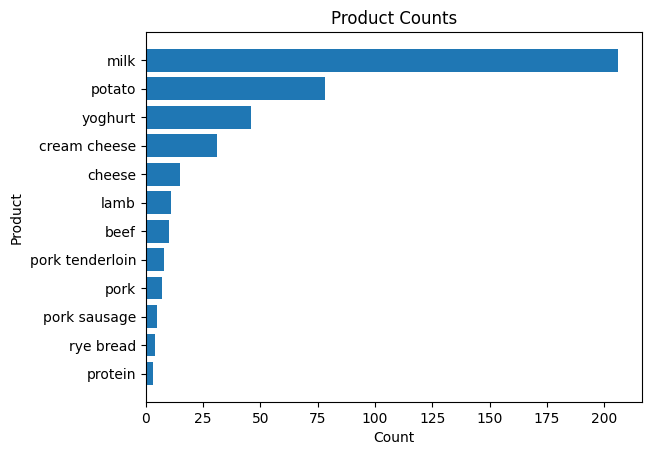

In [19]:
fig, ax1 = plt.subplots()

df_sorted = top_common_items.sort_values("count", ascending=True)

plt.barh(df_sorted["product"], df_sorted["count"])
plt.xlabel("Count")
plt.ylabel("Product")
plt.title("Product Counts")
plt.show()

### Market Based Analysis

The Market-Based Analysis function is designed to match the product list from recipes with the about-to-expire items within a cluster. The process is structured as:
1. Filter for the Selected Cluster:
    - Focus on a specific cluster by isolating its data.
2. Retrieve Expired Products for the Cluster:
    - Collect all items nearing expiration for the cluster.
3. Clean Expired Product Data:
    - Address data noise by removing unnecessary or duplicated words, ensuring consistency.
4. Standardize Recipe Ingredients:
    - Match the cleaned expired products with standardized recipe ingredients for compatibility.
5. Filter Relevant Recipes:
    - Identify recipes containing at least one ingredient from the expired product list of the cluster.
6. Combine Data:
    - Merge the expired product list with recipe ingredients to focus on items relevant to the cluster.
7. Apply Apriori Algorithm:
    - Transform the data (using one-hot encoding) to run the Apriori Algorithm, which identifies frequent itemsets.

The analysis reveals the popular items among recipes sold in the cluster. This allows us to, based on recommend recipes that align with the cluster’s expiring inventory, suggest popular bundles for nearby stores to sell while still study the viability of a possible recommendation system and the connectivity of the most popular products.

In [22]:
def market_based_analysis(cluster_id, expired, recipes, min_support=0.1):
    cluster_stores = expired[expired["cluster_id"] == cluster_id]
    
    cluster_expired_products = []
    for product_list in cluster_stores["product_list"]:
        cluster_expired_products.extend(product_list)
    
    cluster_expired_products = sorted(set(cluster_expired_products))
    print(cluster_expired_products)
    
    
    relevant_recipes = recipes[recipes["product_list"].apply(
        lambda x: any(item in cluster_expired_products for item in x)
    )]
    
    
    transactions = []
    for product_list in relevant_recipes["product_list"]:
        filtered_items = [item for item in product_list if item in cluster_expired_products]
        if filtered_items:
            transactions.append(filtered_items)

    
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
    
    if frequent_itemsets.empty:
        print("No frequent itemsets found.")
        return [], []
    else:
        frequent_itemsets["is_in_cluster"] = frequent_itemsets["itemsets"].apply(
            lambda x: all(item in cluster_expired_products for item in x)
        )
        cluster_itemsets = frequent_itemsets[frequent_itemsets["is_in_cluster"]]
        
        rules = association_rules(cluster_itemsets, metric="lift", min_threshold=1.0)
        
        return cluster_itemsets, rules



In [23]:
cluster_id = 23
frequent_itemsets, rules = market_based_analysis(cluster_id, grouped_products_df, recipes_reworked_df, min_support=0.001)

print(frequent_itemsets)

['attachment', 'bacon', 'beef', 'blue cheese brie', 'buttermilk', 'cheese', 'chicken sausage', 'cold butter milk soup', 'cold coffee drink', 'cold cut', 'cream cheese', 'cream potato', 'dessert snack', 'dinner meal', 'dinner salad', 'dough', 'ham', 'hotdog bun', 'light dark bun', 'liver paste patee', 'lunch meat', 'mayo salad', 'meat ball', 'meat sausage', 'milk', 'mozarella', 'pork', 'pork chop pork schnitzel', 'pork mayo salad', 'pork neck pork loin', 'pork sausage', 'pork veal', 'potato salad', 'poultry mayo salad', 'protein', 'rye bread', 'rye bread carrot', 'saddle pork', 'salami', 'sauce', 'sausage', 'sausage roll', 'skyr', 'sparerib barbecue meat', 'sun flower rye bread', 'thick sausage', 'toast bread', 'whole bread', 'yoghurt']
     support                           itemsets  is_in_cluster
0   0.120588                            (bacon)           True
1   0.026471                             (beef)           True
2   0.026471                       (buttermilk)           True
3 

To showcase diverse recipe possibilities, we created a function that fetches recipes, using frequent itemsets identified by the Apriori Algorithm, and then display the result.

This approach bridges the gap between expiring inventory and popular recipes, providing a practical solution to reduce waste and enhance usability for the food bank.

There are three parameters that we can and should change in order to get not only the best results but the ones that make the most sense in our context:
- The Cluster ID which reflects the food bank that we are investigating.
- The Minimum Support for the Frequent Itemsets which we hoped that would be higher (having more matches) however it was proven the contrary
- The minium items when fiding the recipes just to filter the recipes since so many recipes depend on one-item sets like milk or butter


In [24]:
def find_recipes(frequent_itemsets, recipes, min_items=2):
    itemsets = frequent_itemsets["itemsets"].tolist()

    matching_recipes = []

    for itemset in itemsets:
        # Filter itemsets based on the minimum number of items
        if len(itemset) >= min_items:
            matching = recipes[recipes["product_list"].apply(
                lambda x: set(itemset).issubset(set(x))
            )]

            matching_recipes.append({"itemset": itemset, "recipes": matching})

    return matching_recipes


In [25]:
matching_recipes = find_recipes(frequent_itemsets, recipes_reworked_df, 2)

for match in matching_recipes:
    itemset = match["itemset"]
    recipes_with_itemset = match["recipes"]

    print(f"\nSuggested recipes with: {', '.join(itemset)}")
    print("Matching Recipe Titles:")
    
    for title in recipes_with_itemset["title"]:
        print(f"- {title}")


Suggested recipes with: bacon, buttermilk
Matching Recipe Titles:
- The Ulster fry

Suggested recipes with: bacon, cream cheese
Matching Recipe Titles:
- Waffles with smoked bacon and caramelised peach

Suggested recipes with: bacon, milk
Matching Recipe Titles:
- Bacon and asparagus flan
- Quiche Lorraine
- Waffles with smoked bacon and caramelised peach
- Posh jacket potatoes
- One Pan Pasta with Bacon and Peas Recipe
- Creamy Cowboy Soup Recipe
- Ultimate Twice-Baked Potatoes Recipe
- One Pan Pasta with Bacon and Peas Recipe
- Creamy Cowboy Soup Recipe

Suggested recipes with: bacon, pork sausage
Matching Recipe Titles:
- Gala picnic pie
- Hairy Bikers' sausage casserole
- The Ulster fry

Suggested recipes with: bacon, protein
Matching Recipe Titles:
- Leftover Corn Chowder Recipe

Suggested recipes with: bacon, sausage
Matching Recipe Titles:
- Game terrine
- Waggoners rice
- Tidy Friday pan fry

Suggested recipes with: cheese, beef
Matching Recipe Titles:
- Smash burger

Suggeste

### Getting Popular Bundles

In [ ]:
def suggest_popular_bundles(frequent_itemsets, top_n=5):
    two_item_bundles = frequent_itemsets[frequent_itemsets["itemsets"].apply(len) == 2]
    top_two_item_bundles = two_item_bundles.nlargest(top_n, "support")

    other_bundles = frequent_itemsets[frequent_itemsets["itemsets"].apply(len) > 2]
    top_other_bundles = other_bundles.nlargest(top_n, "support")

    popular_bundles = {
        "two_item_bundles": top_two_item_bundles,
        "three_item_bundles": top_other_bundles,
    }

    return popular_bundles

In [ ]:
popular_bundles = suggest_popular_bundles(frequent_itemsets, top_n=5)

print("Suggested bundles for stores of cluster " + str(cluster_id) + ":")

print("\nTop Two-Item Bundles:")
print(popular_bundles["two_item_bundles"])

print("\nOther Suggested Bundles:")
print(popular_bundles["three_item_bundles"])

Suggested bundles for stores of cluster 23:

Top Two-Item Bundles:
     support               itemsets  is_in_cluster
28  0.028470        (milk, yoghurt)           True
16  0.024911          (milk, bacon)           True
17  0.010676  (bacon, pork sausage)           True
18  0.010676       (bacon, sausage)           True
24  0.010676   (milk, cream cheese)           True

Other Suggested Bundles:
     support                           itemsets  is_in_cluster
29  0.003559  (bacon, buttermilk, pork sausage)           True
30  0.003559        (milk, cream cheese, bacon)           True
31  0.003559       (milk, cream cheese, cheese)           True


As illustrated in the preceding section, our methodology yielded intriguing findings. A number of recommended item combinations were identified from nearby stores that could be valuable for stores to create a bundle on. However, due to the limitations of the word data cleaning process, the computer power available to pull every recipe, and the time constraints that precluded further exploration of options, the results were not as comprehensive as those obtained in the initial market-based analysis. It is crucial to acknowledge that due to the constraints of the data set, the support levels are frequently minimal, with the exception of individual items such as butter, milk, bacon, and cheese. To address this challenge, the supported levels for bundles were modified in a manner that was logical within the context of a store, with consideration given to the recipes included.